In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import matplotlib.colors as colors
import matplotlib.colors as colors
from helpers import *

# Trade Network

In [2]:
import networkx as nx

In [3]:
# Load trade matrix
mat = pd.read_pickle("pickle/trade_matrix.pkl")
mat.head()

Y2000   Y2001   Y2002    Y2003    Y2004    Y2005  \
From        To                                                             
Afghanistan China      2681.5    61.0    40.0    296.0    446.0    678.5   
            Germany      14.0   100.5    19.5    163.5    116.5    356.5   
            India     12650.5  9130.0  8667.5  16268.0  17634.0  25144.0   
            Iran        461.0    58.5    56.5    372.5   1214.0   1737.5   
            Pakistan  12589.5  8157.0  8323.5  10849.0  13144.5   6061.0   

                        Y2006    Y2007    Y2008    Y2009    Y2010    Y2011  \
From        To                                                               
Afghanistan China        16.0    899.0   1135.0   2193.5   6480.5   3625.0   
            Germany     447.5   2241.5    817.0   2024.5   9492.5   4409.5   
            India      9447.0  39789.0  56214.0  86308.0  69985.5  77918.0   
            Iran          0.0      0.0      0.0  16581.5  20263.5   8197.0   
            Pakistan  11909.5  24175.5  21790.0  85256.5  80580.0  66835.5   

                        Y2012    Y2013     Y2014     Y2015     Y2016     Y2017  
From        To                                                                  
Afghanistan China      1423.5   3871.0   13894.5    5270.0     519.5     248.0  
            Germany    1254.5   2839.0    8431.5    3577.5    2955.0    5227.0  
            India     20342.0  86445.0  165823.5  232559.0  198471.5  293335.5  
            Iran          0.0      0.0   13000.0       0.0   16493.5   10589.0  
            Pakistan  59615.5  94408.0  160601.0  250839.5  219945.5  229055.0

In [4]:
# Select countries
countries_total = set(mat.reset_index().From.values).union(mat.reset_index().To.values)

## Visualization: single-country trade relationships

Let's start with an example: China.

In [5]:
# Select China data from trade matrix
china = mat[(mat.reset_index().From=='China').values]
china = china.mean(axis=1)
china = china.reset_index().set_index(['From', 'To']).rename(columns={0:'Value'})
china.head()

Value
From  To                       
China Afghanistan   9411.138889
      Albania       5704.694444
      Algeria      92661.027778
      Argentina    26173.694444
      Armenia       4624.583333

In [6]:
# Select top 30 commercial partners
china = china.sort_values(['Value'], ascending=False)
top30 = china.iloc[:30].reset_index()
countries30 = set(top30.From.values).union(top30.To.values)

In [7]:
# Build graph
G = nx.DiGraph()
G.add_nodes_from(countries30)
G.add_weighted_edges_from(top30.values)

In [8]:
# Set nodes and edges attributes equal to correspondent edge weight
max_value = top30['Value'][0]
nx.set_node_attributes(G, top30.drop('From',axis=1).set_index('To')['Value'].to_dict(), 'Value')
nx.set_node_attributes(G, {'China': max_value}, 'Value')

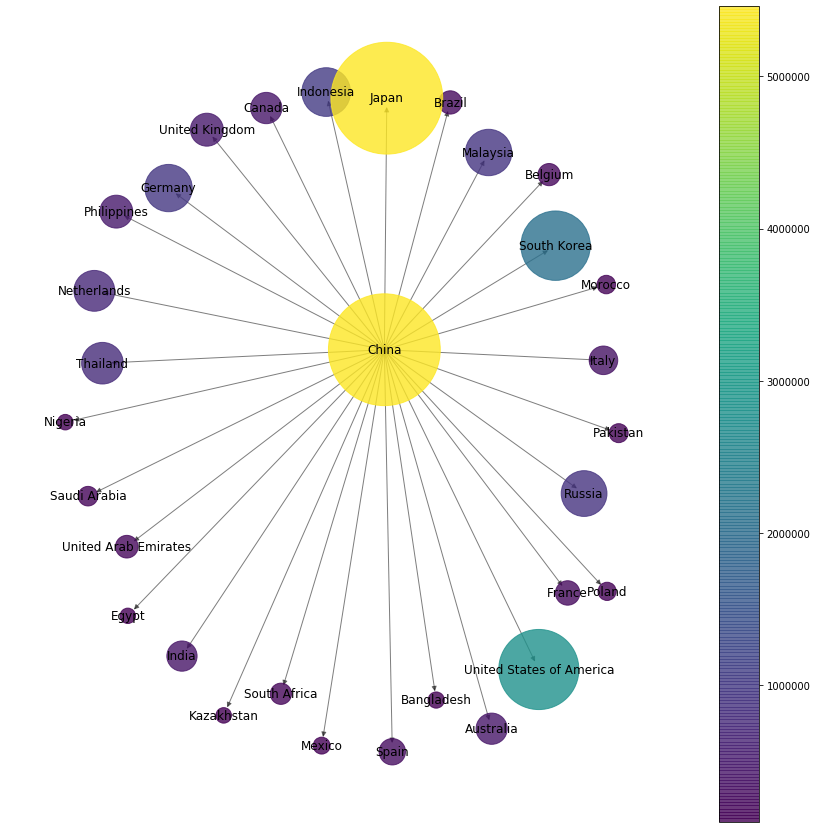

In [9]:
# Plot spring graph
plt.figure(figsize=(15,15)) 
pos = nx.spring_layout(G)
edges = nx.draw_networkx_edges(G, pos, alpha=0.5, edgelist=G.edges(), width=1, with_labels=True)
nodes = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), with_labels=True, 
                               node_color=[nx.get_node_attributes(G,'Value')[n] for n in G.nodes()],
                               node_size=[nx.get_node_attributes(G,'Value')[n] for n in G.nodes()]/max_value*5e4, 
                               alpha=0.8, node_shape = '.', cmap='viridis')
labels = nx.draw_networkx_labels(G,pos)
plt.colorbar(nodes)
plt.axis('off')
plt.show()

We can now define a function which replicates the same operations for a selected country and look at different countries.

In [10]:
def plot_spring(country,n):
    
    center = mat[(mat.reset_index().From==country).values]
    center = center.mean(axis=1)
    center = center.reset_index().set_index(['From', 'To']).rename(columns={0:'Value'})
    center = center.sort_values(['Value'], ascending=False)
    
    top = center.iloc[:n].reset_index()
    countries = set(top.From.values).union(top.To.values)
    
    G = nx.DiGraph()
    G.add_nodes_from(countries)
    G.add_weighted_edges_from(top.values)
    
    max_value = top['Value'][0]
    nx.set_node_attributes(G, top.drop('From',axis=1).set_index('To')['Value'].to_dict(), 'Value')
    nx.set_node_attributes(G, {country: max_value}, 'Value')
    
    plt.figure(figsize=(15,15)) 
    pos = nx.spring_layout(G)
    edges = nx.draw_networkx_edges(G, pos, alpha=0.5, edgelist=G.edges(), width=1, with_labels=True)
    nodes = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), with_labels=True, 
                                   node_color=[nx.get_node_attributes(G,'Value')[n] for n in G.nodes()],
                                   node_size=[nx.get_node_attributes(G,'Value')[n] for n in G.nodes()]/max_value*5e4,
                                   alpha=0.8, node_shape = '.', cmap='viridis')
    labels = nx.draw_networkx_labels(G,pos)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

In [11]:
countries = ['China','United States of America','United Kingdom','France','Germany','Italy','Japan','Brazil']

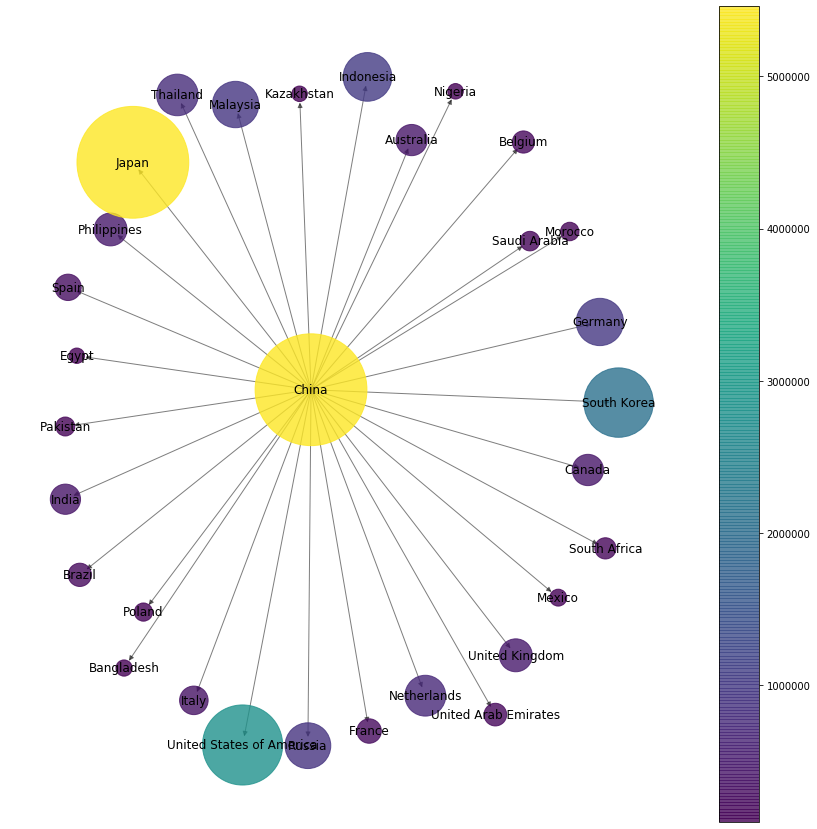

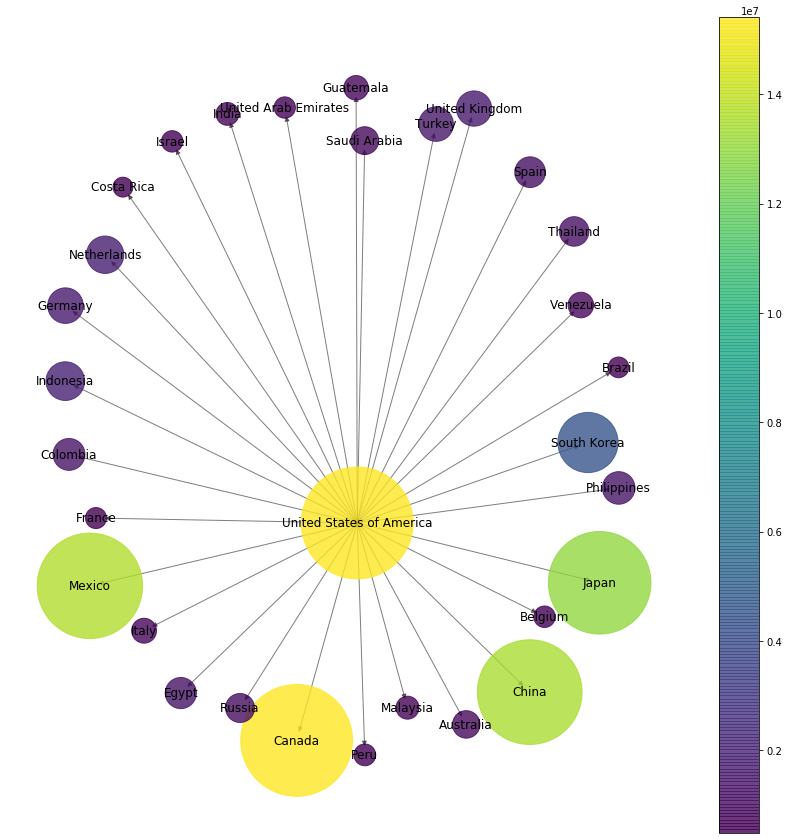

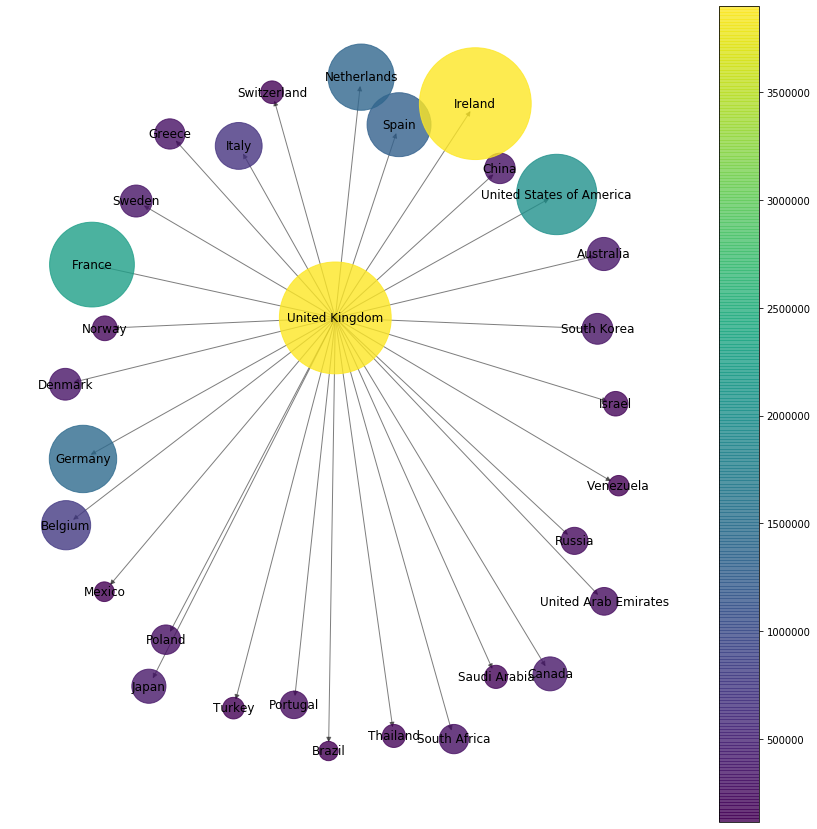

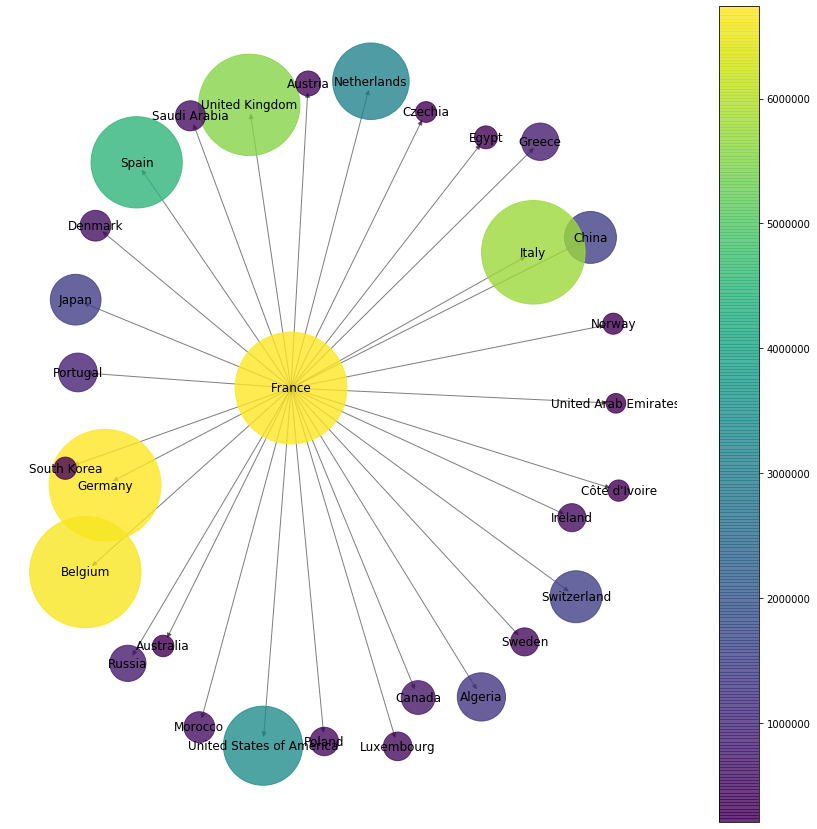

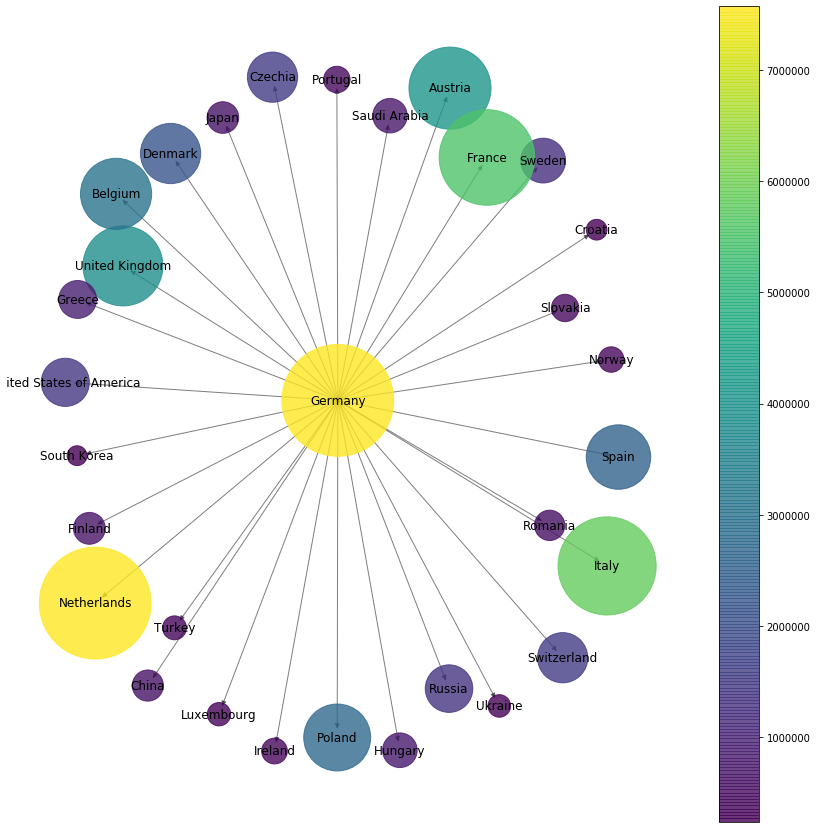

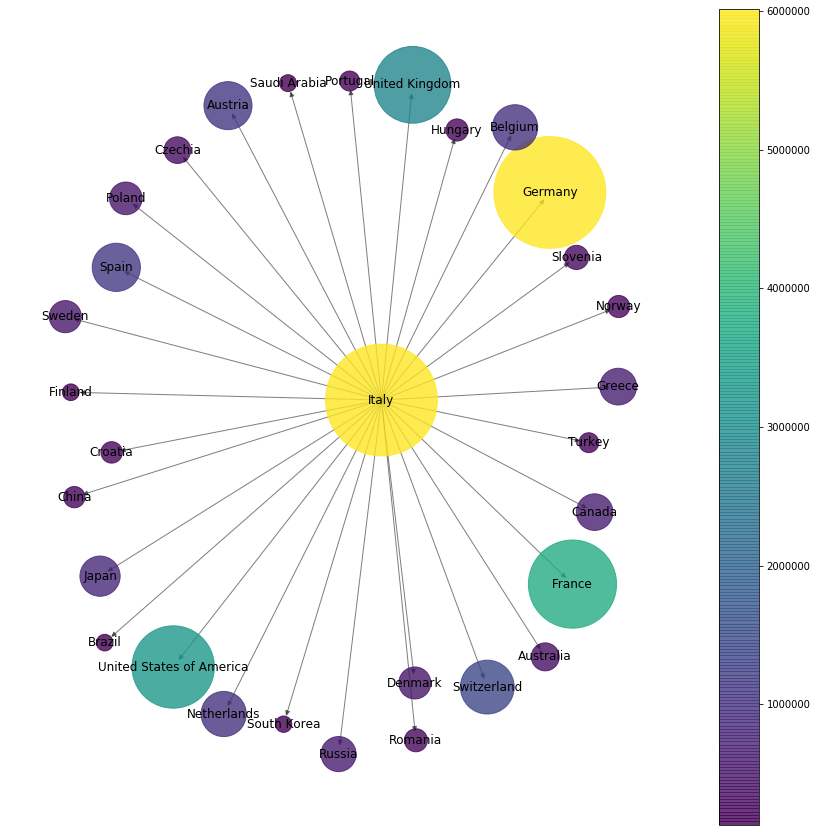

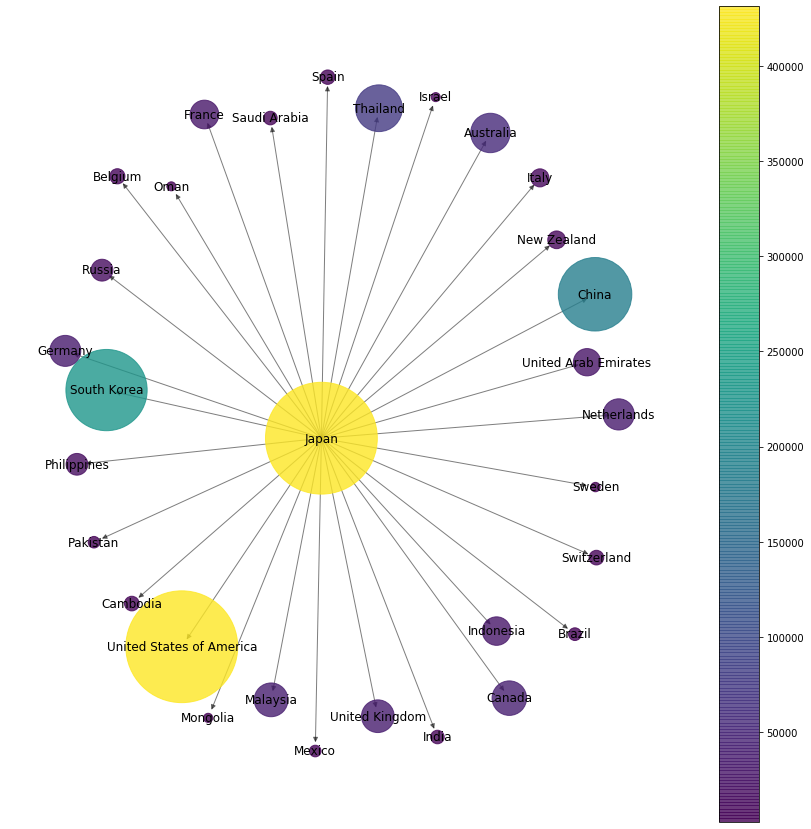

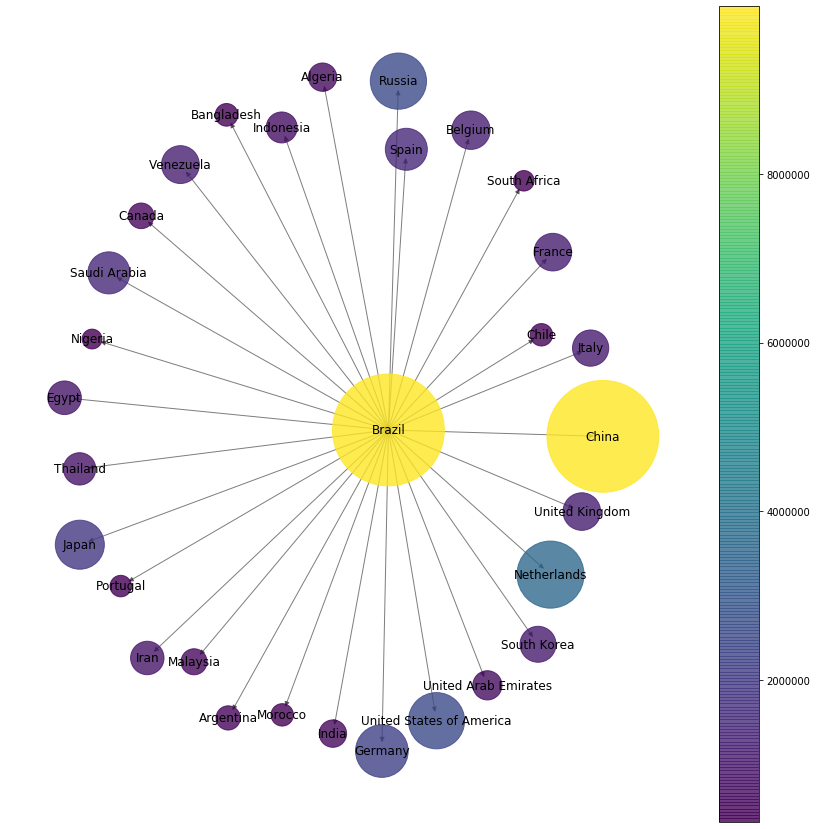

In [12]:
for c in countries:
    plot_spring(c,n=30)

## Visualization: top trading countries

In [13]:
# Top importing and exporting countries
n = 15
top_export = mat.reset_index().groupby('From').sum().mean(axis=1).sort_values(ascending=False)[:n]
top_import = mat.reset_index().groupby('To').sum().mean(axis=1).sort_values(ascending=False)[:n]

In [14]:
# Top countries in both import and export
countries = set(top_export.index).intersection(top_import.index)
countries

{'Belgium',
 'Canada',
 'China',
 'France',
 'Germany',
 'Italy',
 'Netherlands',
 'Spain',
 'United Kingdom',
 'United States of America'}

In [15]:
# Define graph edges with selected countries only
edges = mat.reset_index().loc[mat.reset_index().From.map(lambda x: x in countries),:]
edges = edges.loc[mat.reset_index().To.map(lambda x: x in countries),:]
edges = edges.set_index(['From','To']).mean(axis=1).sort_values(ascending=False)

In [16]:
# Select edges with meaningful size (trades over 5B USD)
edges = edges[edges.values>5e6]

In [17]:
# Build graph
G = nx.DiGraph()
G.add_nodes_from(countries)

In [18]:
# Add weighted edges
G.add_weighted_edges_from(edges.reset_index().values)

In [19]:
# Set nodes attributes
max_value = top_export[0]
nx.set_node_attributes(G, top_export[countries].to_dict(),'Export')

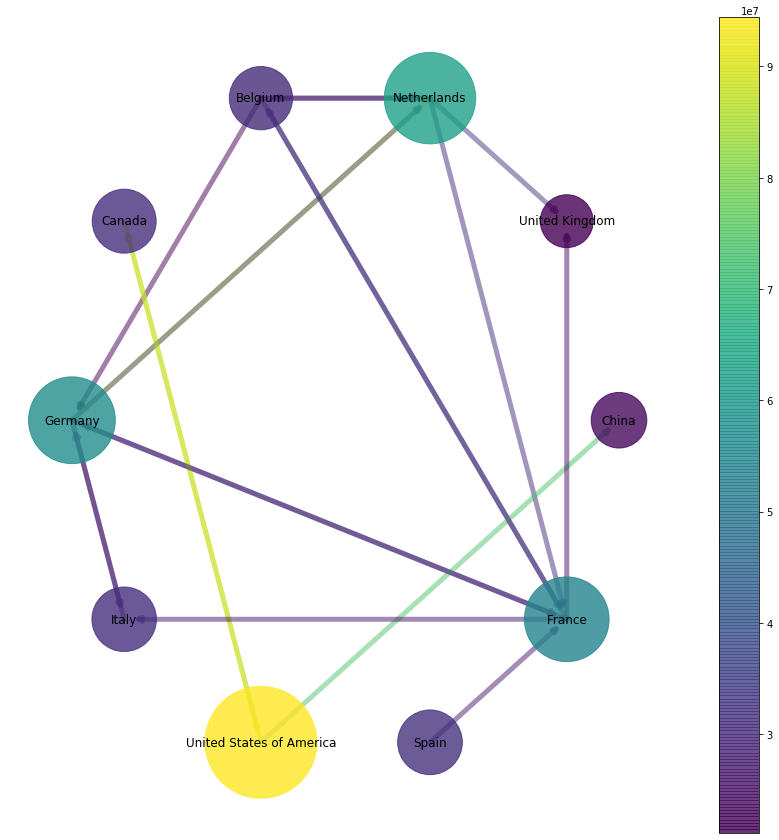

In [20]:
# Plot graph
plt.figure(figsize=(15,15)) 
pos = nx.circular_layout(G)
edges = nx.draw_networkx_edges(G, pos, alpha=0.5, edgelist=G.edges(), width=5, 
                               edge_color=[nx.get_edge_attributes(G,'weight')[e] for e in G.edges()], with_labels=True)
nodes = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), with_labels=True, 
                               node_color=[nx.get_node_attributes(G,'Export')[n] for n in G.nodes()],
                               node_size=[nx.get_node_attributes(G,'Export')[n] for n in G.nodes()]/max_value*5e4, 
                               alpha=0.8, node_shape = '.', cmap='viridis')
labels = nx.draw_networkx_labels(G,pos)
plt.colorbar(nodes)
plt.axis('off')
plt.show()

### Graph centrality: Raw weights

In [21]:
# Define graph
GC = nx.DiGraph()

In [22]:
# Add nodes
GC.add_nodes_from(countries)

In [23]:
# Weighted edges
edges = mat.mean(axis=1)

In [24]:
# Add edges
GC.add_weighted_edges_from(edges.reset_index().values)

In [25]:
# compute eigenvector centrality
eig = nx.eigenvector_centrality_numpy(GC,'weight')
eig = pd.Series(eig).sort_values(ascending=False)

In [26]:
eig.head(10)

United States of America    0.421350
Germany                     0.380337
Japan                       0.327307
China                       0.282327
France                      0.271977
United Kingdom              0.264886
Canada                      0.253817
Netherlands                 0.242446
Italy                       0.221345
Mexico                      0.215367
dtype: float64

### Graph centrality: Normalized weigths

In [27]:
# Load production value
production = pd.read_pickle("pickle/value_production.pkl")

In [28]:
# Total production in recent years
years = ['Y'+str(2000+x) for x in range(0,16)]
production = production[years]

In [29]:
# Reformat production matrix
production = production.join(mat.reset_index().set_index('From').To).reset_index()
production = production.rename(columns={'index':'From'}).set_index(['From','To'])
production = production.loc[production.index.isin(mat.index)]

Before further analysing our trade data, we should be careful with units of measure! Production data are in million USD, while trade data are in thousands USD: we report both in thousands USD (k USD).

In [30]:
# Rescale production values
production = production*1000

In [31]:
# Define normalized matrix
mat_norm = mat[years]/production
mat_norm = mat_norm.replace(np.inf,np.nan).dropna()

In [32]:
# Save normalized matrix to pickle
mat_norm.to_pickle("pickle/trade_matrix_norm.pkl")

In [33]:
# Define graph
GC = nx.DiGraph()

In [34]:
# Add nodes
GC.add_nodes_from(countries)

In [35]:
# Weighted edges
edges = mat_norm.mean(axis=1)

In [36]:
# Add edges
GC.add_weighted_edges_from(edges.reset_index().values)

In [37]:
# Compute eigenvector centrality
eig = nx.eigenvector_centrality_numpy(GC,'weight')
eig = pd.Series(eig).sort_values(ascending=False)

In [38]:
eig.head(10)

Germany                     0.616665
France                      0.420273
United Kingdom              0.345099
Netherlands                 0.280398
Italy                       0.264141
Belgium                     0.220688
United States of America    0.187193
Spain                       0.149383
Austria                     0.089357
Russia                      0.084370
dtype: float64